# Python Project: Retail Customer Segmentation with RFM Model

This project analyzes retail customer transactions data and classifies customers into groups by applying RFM model and quantile scoring method. The objective is to help the business gain insights and run effective marketing campaigns.

RFM model is a marketing concept for segmenting customers based on their buying behaviors in 3 areas: *Recency*, *Frequency*, and *Monetary*.
* Recency (R) measures how recent a customer made a purchase. 
* Frequency (F) measures how often a customer makes purchases.
* Monetary (M) measures how much money a customer has spent.

There are 5 parts in this project:
1. Assaying Data
2. Cleaning Data
3. Manipulating Data
4. Segmentation
5. Summary

## 1. Assaying data

Python libraries like NumPy, Pandas, Matplotlib, and Seaborn are needed for data cleaning, data analysis, and visualization.

In [2]:
# Load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read data in CSV file
df = pd.read_csv('/Users/xsp/Desktop/Datasets/online_retail_data.csv'
                     , parse_dates = ['InvoiceDate'])

df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-01-12 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-01-12 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-01-12 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-01-12 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-01-12 08:34:00,1.69,13047.0,United Kingdom


The data is structured at unique product level since there are many records with the same values in *InvoiceNo*, *InvoiceDate*, and *CustomerID*. In other words, one customer order can result in multiple data records given how many different products purchased.

In [3]:
# Get a concise summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


The dataset contains 541,909 rows and 8 columns. *InvoiceDate* has already been converted to datetime type when reading the file. The rests of them are in acceptable data types. 

In [4]:
# Count distinct values in each field 
df[df.columns].nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

Counting unique values in each column shows that there are more than 4,300 customers from 38 countries having purchased over 4,000 different products in the time period. 

## 2. Data Cleaning

In [5]:
# Check for missing values
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

There are 135,080 records (25% of total) with no customer ID and around 1,400 without description. Only *CustomerID* is important for the analysis so I will drop all rows with null in customerID.

In [6]:
# View records with missing customer ID
df[df['CustomerID'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-01-12 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-01-12 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-01-12 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-01-12 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-01-12 14:32:00,1.66,NaN,United Kingdom


In [7]:
# Drop all rows with null in CustomerID
df.dropna(subset = 'CustomerID', inplace = True) 

df.shape

(406829, 8)

In [8]:
# Check for duplicates
df.duplicated().sum()

5225

There are 5,225 duplicates in this dataset with duplicate values across all columns. 

In [9]:
# Drop duplicates
df.drop_duplicates(keep = 'last', inplace = True)

df.shape

(401604, 8)

In [10]:
# Check data in numeric fields
df[['Quantity', 'UnitPrice']].agg({'Quantity':['min', 'mean', 'max'],
                                   'UnitPrice':['min', 'mean', 'max']})

,Quantity,UnitPrice
min,-80995.000000,0.000000
mean,12.183273,3.474064
max,80995.000000,38970.000000


In [11]:
print(df[df['Quantity'] <= 0].shape[0])
print(df[df['UnitPrice'] == 0].shape[0])
print(df[(df['Quantity'] <= 0) | (df['UnitPrice'] == 0)].shape[0])

8872
40
8912


There are 8,872 records with negative values in *Quantity* and 40 records with zero in *UnitPrice* (8,912 with either condition).

In [12]:
# Exclude rows with negative or zero in both fields
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

df.shape

(392692, 8)

## 3. Data Manipulation

These are new columns needed for RFM Analysis:
* *SumTotal*: quantity times unit price (will be used as input for *Monetary*).
* *Recency*: number of days from “current” date.
* *Frequency*: count of unique invoices.
* *Monetary*: sum of dollar values from all purchases.

***Note***: Recency, Frequency, and Monetary columns are to be aggregated by each customer (or CustomerID).

In [13]:
# Create SumTotal column
df['SumTotal'] = df['Quantity'] * df['UnitPrice']

df[['Quantity', 'UnitPrice', 'SumTotal']].head()

,Quantity,UnitPrice,SumTotal
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34


In [14]:
# Find the average customer spending per time
basket_size = df.groupby('InvoiceNo')['SumTotal'].sum()

print('The average basket size per shopping time is $',
      round(basket_size.mean(), 2))

The average basket size per shopping time is $ 479.56


In [15]:
# Recency column
recency_df = (df['InvoiceDate'].max() - df.groupby('CustomerID')['InvoiceDate'].max()).dt.days

# Frequency column
frequency_df = df.groupby('CustomerID')['InvoiceNo'].nunique()

# Monetary column
monetary_df = df.groupby('CustomerID')['SumTotal'].sum()

# Merge RFM columns into a new dataframe
final_df = pd.merge(recency_df, frequency_df, on = 'CustomerID', how = 'inner')
final_df = pd.merge(final_df, monetary_df, on = 'CustomerID', how = 'inner')

# Rename the columns
final_df.rename(columns = {'InvoiceDate':'Recency',
                           'InvoiceNo':'Frequency',
                           'SumTotal':'Monetary'},
                            inplace = True)
final_df

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,40,7,4310.00
12348.0,76,4,1797.24
12349.0,19,1,1757.55
12350.0,311,1,334.40
...,...,...,...
18280.0,160,1,180.60
18281.0,4,1,80.82
18282.0,216,2,178.05


*Frequency* is created by counting *InvoiceNo* and *Monetary* is created by adding values in *SumTotal*. *Recency* is created by subtracting each customer’s latest invoice date with the overall latest invoice date as this dataset isn’t current.

In [16]:
round(final_df.describe(), 2)

,Recency,Frequency,Monetary
count,4338.00,4338.00,4338.00
mean,105.47,4.27,2048.69
std,115.08,7.70,8985.23
min,0.00,1.00,3.75
25%,22.00,1.00,306.48
50%,61.00,2.00,668.57
75%,161.75,5.00,1660.60
max,697.00,209.00,280206.02


**Recency:**  
* Recency values between 0 and 697 days, with average value at 3.5 months.
* Around 50% of the customers made a purchase within the last 2 months.  

**Frequency:**  
* On average, a customer has shopped on the site 4-5 times in the 2-year period.  
* The most active customer has shopped for 209 times or roughly twice a week.

**Monetary:** 
* The total spending is 2,049 on average, with values varying from 4 all the way to 280,206.
* The mean value is a lot higher than the median, suggesting that some customers have extremely high spending.

Visualizing the distribution of data with histogram.

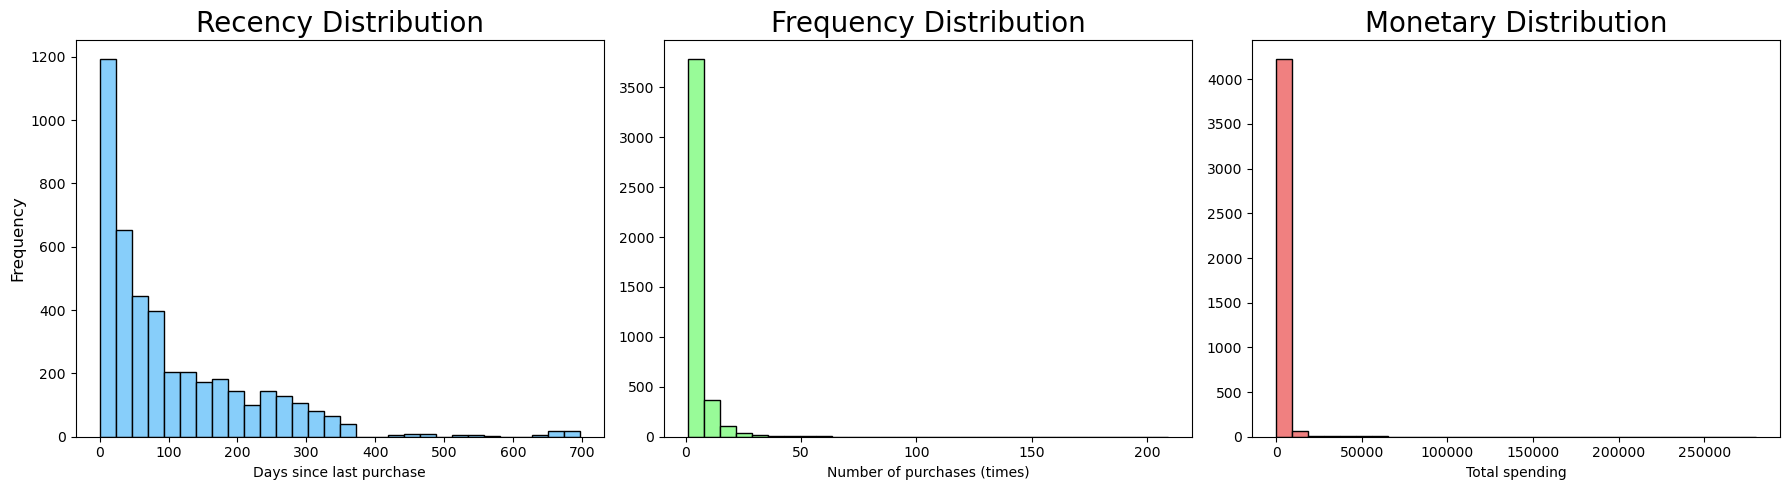

In [17]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 5))

# Recency Histogram
axes[0].hist(final_df['Recency'], bins = 30, color = 'lightskyblue', edgecolor = 'black')
axes[0].set_title('Recency Distribution', fontsize = 20)
axes[0].set_xlabel('Days since last purchase')
axes[0].set_ylabel('Frequency', fontsize = 12)

# Frequency Histogram 
axes[1].hist(final_df['Frequency'], bins = 30, color = 'palegreen', edgecolor = 'black')
axes[1].set_title('Frequency Distribution', fontsize = 20)
axes[1].set_xlabel('Number of purchases (times)')

# Monetary Histogram
axes[2].hist(final_df['Monetary'], bins = 30, color = 'lightcoral', edgecolor = 'black')
axes[2].set_title('Monetary Distribution', fontsize = 20)
axes[2].set_xlabel('Total spending')

plt.tight_layout()
plt.show()

All three charts above show that the majority of the data is concentrated in the leftmost bin, with a small amount of outliers stretching to the right ends. These small portions are skewing the data potentailly giving bias results; thus, they should be removed.

In [18]:
# Remove outliers

Q1 = final_df.quantile(0.25)
Q3 = final_df.quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - (IQR * 1.5)  
upper_limit = Q3 + (IQR * 1.5)

final_df = final_df[(final_df[final_df.columns] >= lower_limit) 
                  & (final_df[final_df.columns] <= upper_limit)]

filtered_df = final_df.dropna()
filtered_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12348.0,76.0,4.0,1797.24
12349.0,19.0,1.0,1757.55
12350.0,311.0,1.0,334.40
12352.0,73.0,8.0,2506.04
12353.0,204.0,1.0,89.00


The RFM table is ready for next steps.

## 4. Segmentation

I will conduct 2 styles of segmentation:

1. **Broad segmentation** — grouping customers into 3 tiers for a quick understanding.
2. **Detailed segmentation** — grouping customers into hundreds of RFM types for more accurate characterizing.  

For both styles, I will create new columns by assigning score of 1–5 to each customer based on relative performance to all customers — this is known as quantile scoring. In this case, a score of 5 would mean good and 1 would mean bad.  

***Note:*** Having high Recency is considered as bad, therefore it would get a lower score, while having high Frequency or Monetary is the opposite.

In [19]:
# Assign score 1-5 based on quantile performance

rfm_df = filtered_df.copy()

rfm_df['RecencyScore'] = pd.qcut(filtered_df['Recency'], 5, labels = [5, 4, 3, 2, 1])
rfm_df['FrequencyScore'] = pd.qcut(filtered_df['Frequency'].rank(method = 'first'), 5, labels = [1, 2, 3, 4, 5])
rfm_df['MonetaryScore'] = pd.qcut(filtered_df['Monetary'], 5, labels = [1, 2, 3, 4, 5])

rfm_df.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore
CustomerID,,,,,,
12348.0,76.0,4.0,1797.24,3,4,5
12349.0,19.0,1.0,1757.55,5,1,5
12350.0,311.0,1.0,334.40,1,1,2
12352.0,73.0,8.0,2506.04,3,5,5
12353.0,204.0,1.0,89.00,1,1,1


For broad segmentation, all 3 scores will be summed into a single “RFM score”.  
* Example: if a customer scores full mark on Recency, Frequency, and Monetary, they would get 15 score.  

For detailed segmentation, all 3 scores will be concated into “RFM type”
* Example: if a customer scores full mark on Recency, Frequency, and Monetary, they would get a “555” RFM type.

In [20]:
# Create RFMScore column
r = pd.to_numeric(rfm_df['RecencyScore'])
f = pd.to_numeric(rfm_df['FrequencyScore'])
m = pd.to_numeric(rfm_df['MonetaryScore'])

rfm_df['RFMScore'] = r + f + m

# Create RFMType column
R = rfm_df['RecencyScore'].astype('str')
F = rfm_df['FrequencyScore'].astype('str')
M = rfm_df['MonetaryScore'].astype('str')

rfm_df['RFMType'] = R + F + M

rfm_df.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMScore,RFMType
CustomerID,,,,,,,,
12348.0,76.0,4.0,1797.24,3,4,5,12,345
12349.0,19.0,1.0,1757.55,5,1,5,11,515
12350.0,311.0,1.0,334.40,1,1,2,4,112
12352.0,73.0,8.0,2506.04,3,5,5,13,355
12353.0,204.0,1.0,89.00,1,1,1,3,111


Last step for broad segmentation is to assign groups according to the following:
- Tier 1 = Customers with RFM score above 13  
- Tier 2 = Customers with RFM score between 13 and 7  
- Tier 3 = Customers with RFM score below 7

In [27]:
# Assign broad groups to each customer (broad segmentation)

def segmentation(x):
    if x > 13:
        return 1
    elif x <= 13 & x > 6:
        return 2
    else:
        return 3
    
rfm_df['Group'] = rfm_df['RFMScore'].apply(segmentation)
rfm_df.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMScore,RFMType,Group
CustomerID,,,,,,,,,
12348.0,76.0,4.0,1797.24,3,4,5,12,345,2
12349.0,19.0,1.0,1757.55,5,1,5,11,515,3
12350.0,311.0,1.0,334.40,1,1,2,4,112,3
12352.0,73.0,8.0,2506.04,3,5,5,13,355,2
12353.0,204.0,1.0,89.00,1,1,1,3,111,3


In [22]:
# Count customers in each group
rfm_df['Group'].value_counts()

3    2049
2    1259
1     477
Name: Group, dtype: int64

Out of 3,785 customers in the final table:  
- 13% is in tier 1.
- 33% is in tier 2.
- 54% is in tier 3.

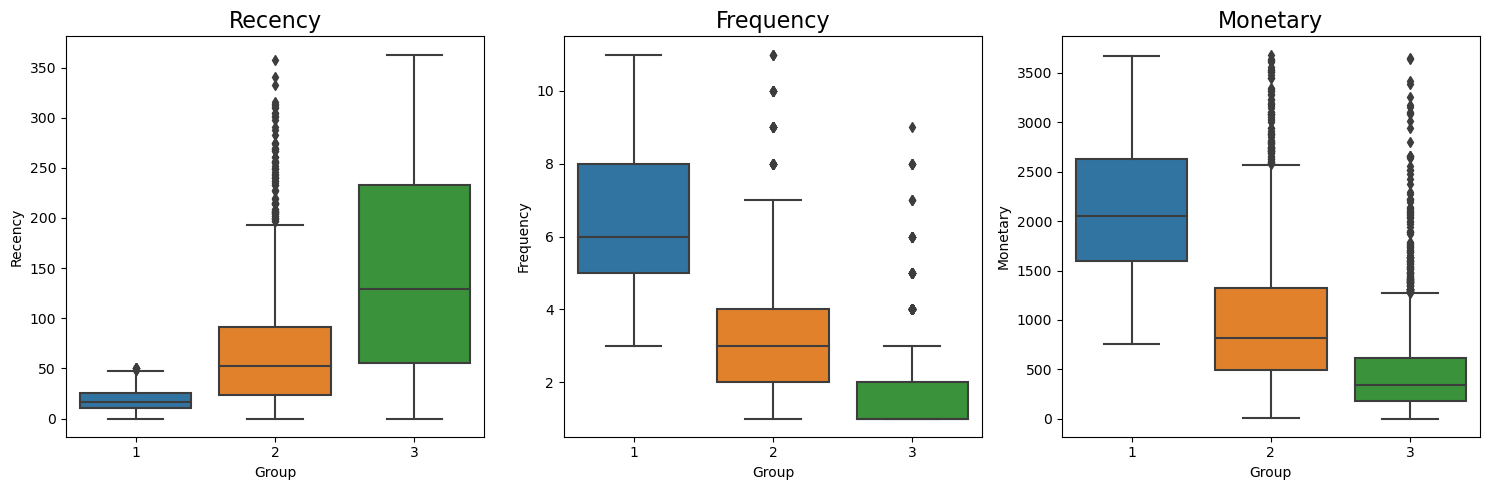

In [23]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))

# Boxplot for Recency
sns.boxplot(x = 'Group', y = 'Recency', data = rfm_df, ax = axs[0])
axs[0].set_title('Recency', fontsize = 16)

# Boxplot for Frequency
sns.boxplot(x = 'Group', y = 'Frequency', data = rfm_df, ax = axs[1])
axs[1].set_title('Frequency', fontsize = 16)

# Boxplot for Monetary
sns.boxplot(x = 'Group', y = 'Monetary', data = rfm_df, ax = axs[2])
axs[2].set_title('Monetary', fontsize = 16)


plt.tight_layout()
plt.show()

## 5. Summary

**A. Broad Segmentation**

This is a 3-tier breakdown using total RFM score to help understand where customers are in terms of recency, frequency, and monetary aspects.

|  Group | Description  |
|:---|:---|
| Tier 1 | Customers in tier 1 are the most valuable to the business. They are highly engaged, making purchases recently, spending significantly more money than other tiers, and doing so frequently. They are likely to be loyal and are overall happy with the service; thus, should be the top priority for retention efforts and exclusive rewarding program. | 
| Tier 2 | Customers in tier 2 are moderately recent and frequent, and spend a decent amount of money on their purchases. They represent regular and consistent shoppers. Some of them spend as much and as frequent as tier 1 customers. The business should implement tactics to increase their frequency and spending such as personalized upselling and cross-selling. They should also nurture high potential customers with incentives. | 
| Tier 3 | Customers in tier 3 purchase occasionally and spend relatively less money. The customers has a high average recency, indicating that they haven't made a purchase recently. They are likely a seasonal shopper, unhappy buyers, or new customers. The business should aim to increase engagement with welcome offers and re-engagement campaigns. | 

In [24]:
# Stats for broad segmentation
report_1 = rfm_df.groupby('Group')[['Recency', 'Frequency', 'Monetary']].agg(['min', 'mean', 'max'])
report_1

Recency                    Frequency                 Monetary  \
          min        mean    max       min      mean   max      min   
Group                                                                 
1         0.0   17.461216   50.0       3.0  6.595388  11.0   761.59   
2         0.0   69.789515  358.0       1.0  3.142176  11.0     6.90   
3         0.0  146.471938  363.0       1.0  1.709126   9.0     3.75   

                             
              mean      max  
Group                        
1      2122.597358  3672.86  
2      1019.647212  3683.86  
3       492.711393  3651.27

**B. Detailed Segmentation**

This segmenting style is more detailed and can better capture customer behavior and value. In total, there are 125 RFM types but we will focus on 7 main types and what actions to take.

| RFM Type | Customer Type | RFM Characteristics  | Action |
|:---:|:---|:---|:---|
| 555 | Ideal Customers  | Customers who bought most recently, most frequently, and spend the most. These are the best customers who you don't want to lose.  | Prioritize exclusive rewards, personalized experience, and retention program. Make them feel highly valued. |
| x5x | Loyal Customers  | Customers who purchase very often and are likely loyal. They are repeat visitors with the highest potential to become ideal customers.| Encourage them to stick around and spend more with benefits like free shopping, value-added offers, loyalty rewards, and advocacy campaigns. Use R and M to segment further. | 
| xx5 | Big Spenders  | Customers who spend the most on their purchases. They are likely to have high budget and willing to pay for what they like. | Consider premium offers and high quality products. Use R and F to segment further. |
| 51x | Newcomers  | Customers who purchase very recently but not often. They are likely new customers. | Utilized triggered welcome emails, starter offers, and membership. Share useful information about service and benefits. |
| 255 | Almost Lost  | Customers who haven't purchased for some time but purchased frequently and spend the most. They are valuable customers with potential to churn.  | Implement churn prevention plans such as sending personalized messages based on their purchase history. |
| 155 | Lost High Value  | Customers who haven't purchased for a long time, but previously active and spend a lot. They likely have churned. | Re-engage them with aggressive discounts and incentives. |
| 111 | Lost Low Value  | Customers who are the least recent, frequent, and spend the least. | Don't spend too much trying to re-acquire as they are the least valuable type. |

In [29]:
# Stats for detailed segmentation
# Use 'pd.options.display.max_rows = 125' to show all the rows

report_2 = rfm_df.groupby('RFMType')[['Recency', 'Frequency', 'Monetary']].agg(['min', 'mean', 'max'])

report_2

Recency                    Frequency                 Monetary  \
            min        mean    max       min      mean   max      min   
RFMType                                                                 
111       193.0  280.555556  363.0       1.0  1.000000   1.0    30.60   
112       193.0  276.482353  362.0       1.0  1.000000   1.0   236.04   
113       193.0  274.463415  358.0       1.0  1.000000   1.0   439.03   
114       201.0  261.857143  336.0       1.0  1.000000   1.0   775.85   
115       197.0  283.166667  320.0       1.0  1.000000   1.0  1542.08   
...         ...         ...    ...       ...       ...   ...      ...   
551        12.0   12.000000   12.0       7.0  7.000000   7.0   201.12   
552        15.0   16.000000   17.0       6.0  6.000000   6.0   306.72   
553         0.0   10.928571   17.0       4.0  4.714286   6.0   477.83   
554         0.0   10.719512   20.0       4.0  5.792683  10.0   761.59   
555         0.0   10.402844   20.0       4.0  7.018957  11.0  1432.77   

                               
                mean      max  
RFMType                        
111       141.456889   229.47  
112       330.167765   418.92  
113       525.875854   741.26  
114      1080.933810  1384.25  
115      2062.231667  3096.00  
...              ...      ...  
551       201.120000   201.12  
552       353.790000   400.86  
553       632.822143   732.07  
554      1131.476707  1427.57  
555      2323.240379  3641.32  

[125 rows x 9 columns]

This is the end of the project.